<a href="https://colab.research.google.com/github/Randhir123/quant/blob/main/Time_series_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
!pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.4 MB/s eta 0:00:00


In [146]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import gc
import os
import random
import copy
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from pyts.image import GramianAngularField

We'll analyze the closing price of AAPL stocks.

[*********************100%%**********************]  1 of 1 completed


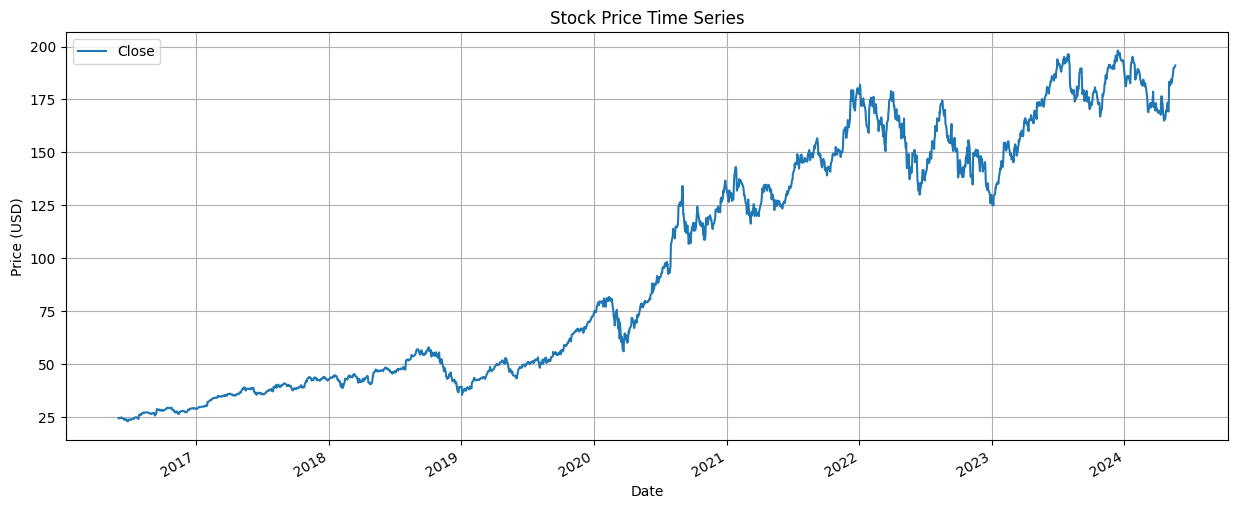

In [24]:
# Load stock price data
df = yf.download("AAPL", start="2016-06-01", end="2024-05-21")
df=df.drop(columns=['Open','High','Low','Volume', 'Adj Close'])

# Plot the original time series
df.plot(figsize=(15,6))
plt.title('Stock Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

Let's check the summary statistics.

In [25]:
# Summary statistics
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
             Close
count  2006.000000
mean     98.450604
std      56.856812
min      23.010000
25%      43.598126
50%      80.936249
75%     150.799999
max     198.110001


Usually univariate time series analysis is done on a stationary series, so first off we'll check for stationarity.

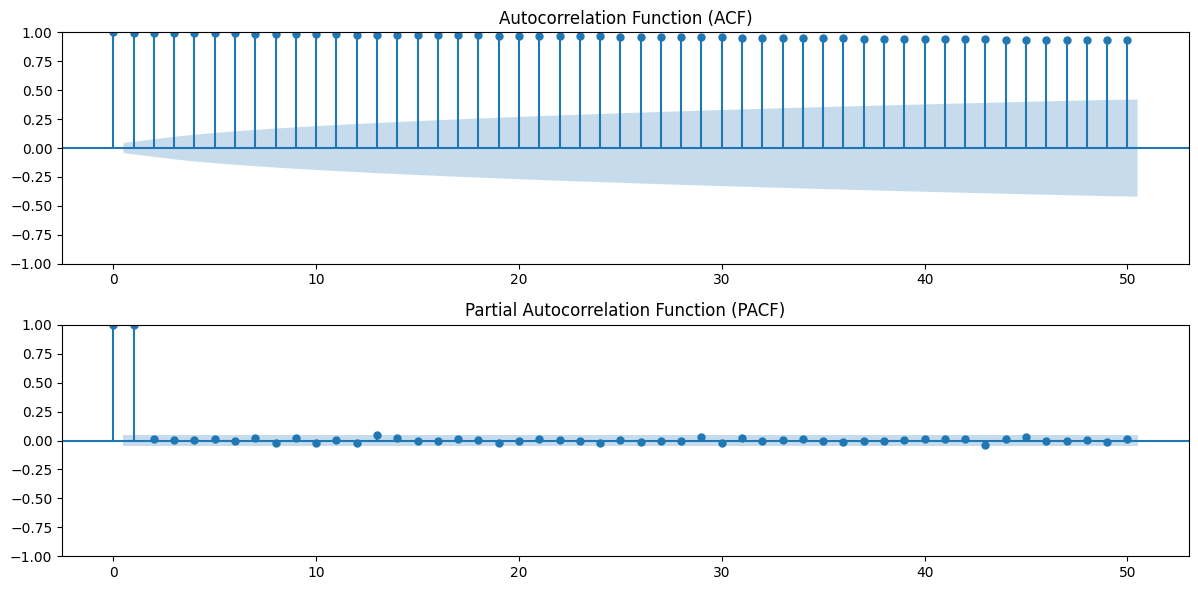

In [26]:
# ACF and PACF plots for persistence

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df, ax=plt.gca(), lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.subplot(2, 1, 2)
plot_pacf(df, ax=plt.gca(), lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [27]:
# Augmented Dickey-Fuller (ADF) test for stationarity
adf_result = adfuller(df)
print("\nADF Test Results:")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value}")


ADF Test Results:
ADF Statistic: -0.4605141594598856
p-value: 0.8994943104821944
Critical Values:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156


The ADF statistic is larger than the critical values at different level of significance. We cannot reject the null hypothesis of non-stationarity.

Let's use the logarithm of the original series.

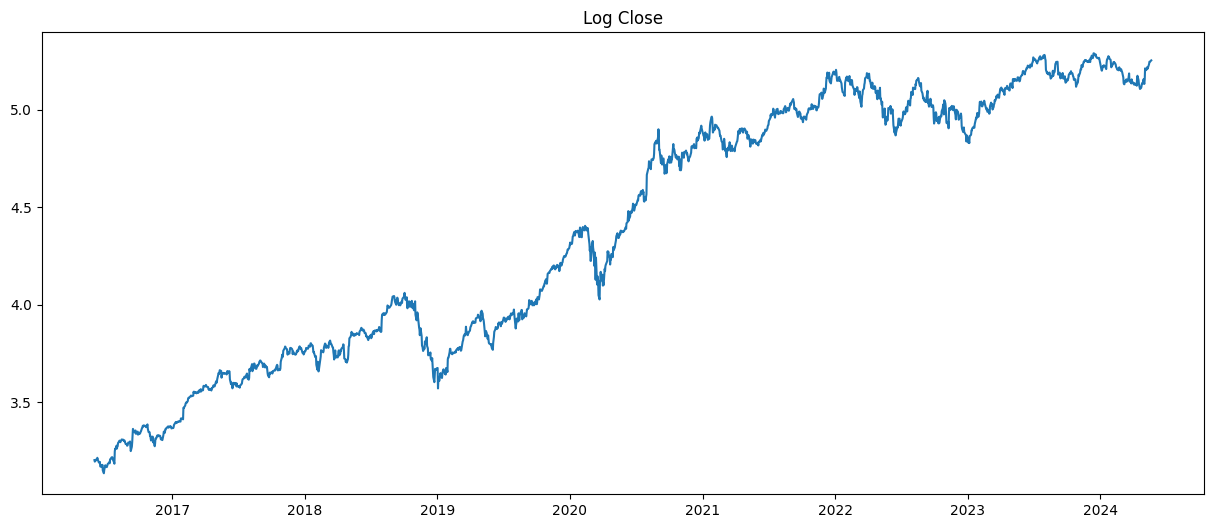

In [28]:
df_log = pd.DataFrame(np.log(df['Close']),index=df.index)
plt.figure(figsize=(15,6))
plt.plot(df_log)
plt.title('Log Close')
plt.show()

In [29]:
# Augmented Dickey-Fuller (ADF) test for stationarity
adf_result = adfuller(df_log)
print("\nADF Test Results:")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value}")


ADF Test Results:
ADF Statistic: -1.2776245051912318
p-value: 0.6393459548923692
Critical Values:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156


The log of the series is also non-stationary. Some common techniques to make time series data stationary:


* **Differencing**: Take the difference between consecutive observations.
* **Transformation**: Apply transformations such as logarithmic transformation
* **Fractional Differencing**



##Differencing

Let's now try to difference the series or the log of the series.

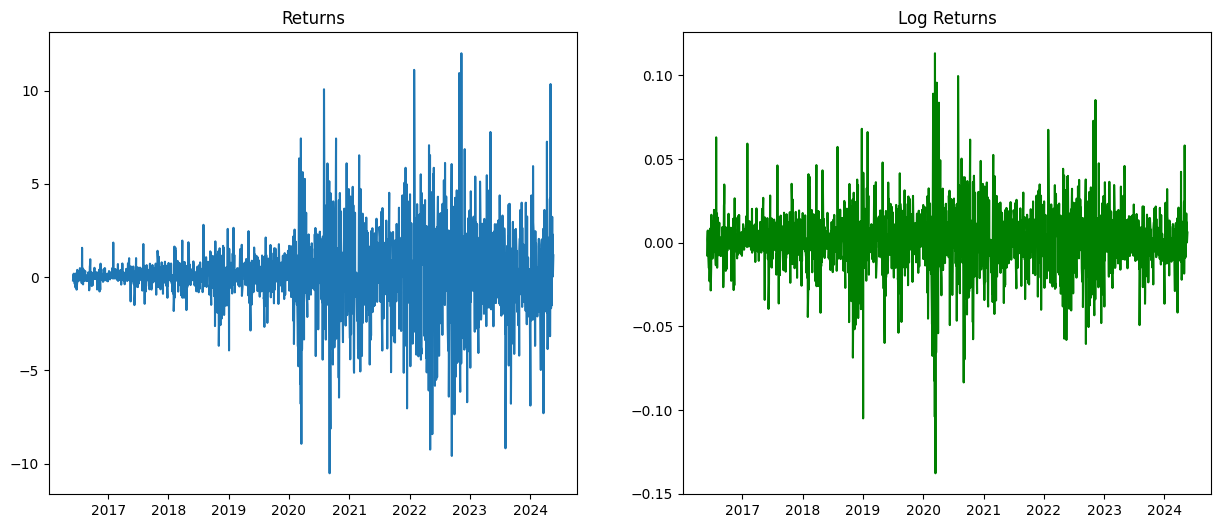

In [30]:
df['Returns']=df['Close']-df['Close'].shift(1)
df_log['Log_Returns']=df_log['Close']-df_log['Close'].shift(1)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(df['Returns'])
plt.title('Returns')
plt.subplot(1,2,2)
plt.plot(df_log['Log_Returns'],'g-')
plt.title('Log Returns')
plt.show()

Let's check both of our new series through the ADF test.

In [31]:
adf_result_returns = adfuller(df['Returns'].dropna())
print("\nADF Test Results for Returns:")
print("ADF Statistic:", adf_result_returns[0])
print("p-value:", adf_result_returns[1])
print("Critical Values:")
for key, value in adf_result_returns[4].items():
    print(f"\t{key}: {value}")


adf_result_log_returns = adfuller(df_log['Log_Returns'].dropna())
print("\nADF Test Results for Log_Returns:")
print("ADF Statistic:", adf_result_log_returns[0])
print("p-value:", adf_result_log_returns[1])
print("Critical Values:")
for key, value in adf_result_log_returns[4].items():
    print(f"\t{key}: {value}")


ADF Test Results for Returns:
ADF Statistic: -14.606628895391774
p-value: 4.084929825598094e-27
Critical Values:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156

ADF Test Results for Log_Returns:
ADF Statistic: -14.068038529279898
p-value: 2.974401974504954e-26
Critical Values:
	1%: -3.433630425730241
	5%: -2.862989113874071
	10%: -2.5675414465504156


We have stationary series that we can now work with for our forecasts.

##Fractional Differencing
Next, let's use an approach called fractional differencing. Using fractionally differenced variables as dependent variables or features for time series modelling could improve predictive performance in many cases because the time series is allowed to retain more memory while still being stationary.

In [32]:
def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1)
    return w
def plotWeights(dRange, lags, numberPlots):
    weights=pd.DataFrame(np.zeros((lags, numberPlots)))
    interval=np.linspace(dRange[0],dRange[1],numberPlots)
    for i, diff_order in enumerate(interval):
        weights[i]=getWeights(diff_order,lags)
    weights.columns = [round(x,2) for x in interval]
    fig=weights.plot(figsize=(15,6))
    plt.legend(title='Order of differencing')
    plt.title('Lag coefficients for various orders of differencing')
    plt.xlabel('lag coefficients')
    #plt.grid(False)
    plt.show()
def ts_differencing(series, order, lag_cutoff):
    # return the time series resulting from (fractional) differencing
    # for real orders order up to lag_cutoff coefficients

    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:]

In [33]:
df['Fractional'] = ts_differencing(df['Close'],0.9,20)
df_log['Fractional'] = ts_differencing(df_log['Close'],0.9,20)

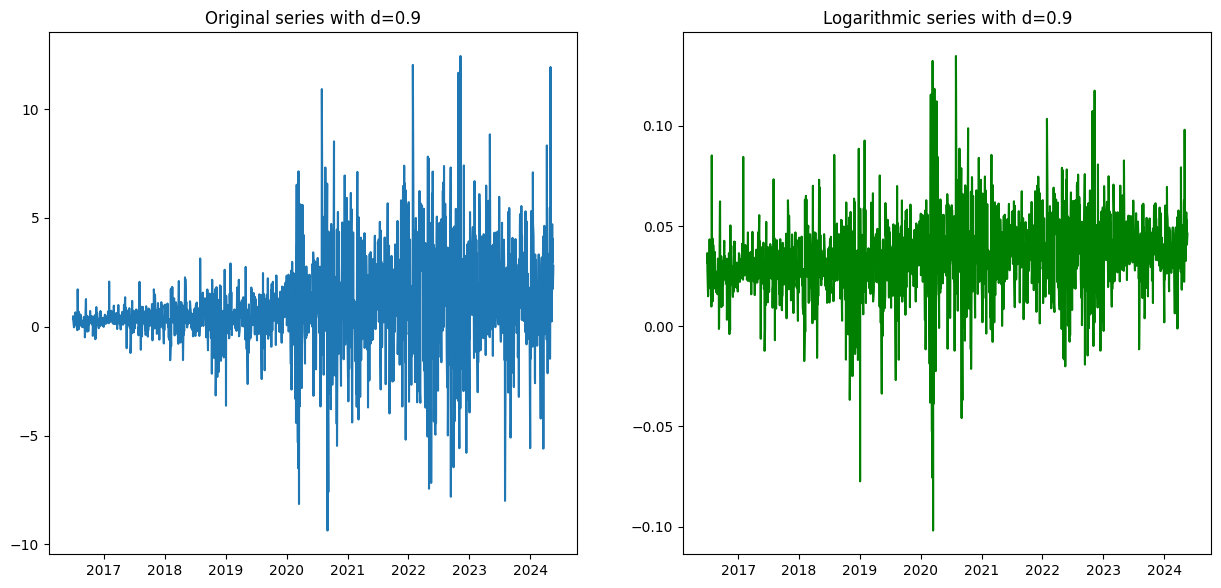

In [34]:
differences=[0.9]
fig, axs = plt.subplots(len(differences),2,figsize=(15,6))
for i in range(0,len(differences)):
    axs[0].plot(df['Fractional'])
    axs[0].set_title('Original series with d='+str(differences[i]))
    axs[1].plot(df_log['Fractional'],'g-')
    axs[1].set_title('Logarithmic series with d='+str(differences[i]))
    plt.subplots_adjust(bottom=0.01) #increasing space between plots for aestethics

Let's check both of our new series through the ADF test.

In [35]:
adf_result_fractional = adfuller(df['Fractional'].dropna())
print("\nADF Test Results for Fractional:")
print("ADF Statistic:", adf_result_fractional[0])
print("p-value:", adf_result_fractional[1])
print("Critical Values:")
for key, value in adf_result_fractional[4].items():
    print(f"\t{key}: {value}")


adf_result_log_fractional = adfuller(df_log['Fractional'].dropna())
print("\nADF Test Results for Fractional:")
print("ADF Statistic:", adf_result_log_fractional[0])
print("p-value:", adf_result_log_fractional[1])
print("Critical Values:")
for key, value in adf_result_log_fractional[4].items():
    print(f"\t{key}: {value}")


ADF Test Results for Fractional:
ADF Statistic: -7.401482908989515
p-value: 7.534908468166931e-11
Critical Values:
	1%: -3.4336771595431106
	5%: -2.863009746829746
	10%: -2.5675524325901415

ADF Test Results for Fractional:
ADF Statistic: -6.328209788530858
p-value: 2.9503178659131254e-08
Critical Values:
	1%: -3.4336788532475775
	5%: -2.8630104945933974
	10%: -2.567552830738709


After fractional differencing, the series is stationary.

In [36]:
df.tail()

,Close,Returns,Fractional
Date,,,
2024-05-14,187.429993,1.149994,2.954432
2024-05-15,189.720001,2.290009,4.046171
2024-05-16,189.839996,0.119995,1.981708
2024-05-17,189.869995,0.029999,1.736780
2024-05-20,191.039993,1.169998,2.794917


##Multi-Layer Perceptron model (MLP or Artificial Neural Network)

In [126]:
def train_test_data(target_variable):
  df_copy = df.loc[:,df.columns.isin([target_variable])]

  # Creating input features by shifting the target variable
  look_back = 5  # Number of past time steps to consider
  for i in range(1, look_back+1):
    df_copy[f'lag_{i}'] = df_copy[target_variable].shift(i)

  df_copy.dropna(inplace=True)

  X = df_copy.iloc[:, 1:].values  # Input features
  y = df_copy[target_variable].values  # Target variable

  # Calculate the index to split the data
  split_index = int(len(df_copy) * 0.8)  # Use 80% of the data for training

  # Split the data into training and testing sets
  train_data = df_copy.iloc[:split_index]
  test_data = df_copy.iloc[split_index:]
  return train_data, test_data

In [139]:
def mlp(target_variable, train_data, test_data):
  # Extract input features and target variable for training and testing sets
  X_train = train_data.iloc[:, 1:].values
  y_train = train_data[target_variable].values
  X_test = test_data.iloc[:, 1:].values
  y_test = test_data[target_variable].values

  model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer with 1 neuron for regression
  ])

  hp_lr = 1e-5  # Learning rate
  adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
  model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])

  model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

  loss, mae = model.evaluate(X_test, y_test)
  print("Test Loss:", loss)
  print("Test MAE:", mae)

  predictions = model.predict(X_test)

  plt.figure(figsize=(20, 6))
  plt.plot(y_test, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Actual vs. Predicted Values ({target_variable})')
  plt.xlabel('Time')
  plt.ylabel('Close Price')
  plt.legend()
  plt.grid(True)
  plt.show()

###Predicting Price Levels

Epoch 1/50


<ipython-input-126-6d0afc0da764>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target[f'lag_{i}'] = df_target[target_variable].shift(i)


40/40 [==============================] - 1s 7ms/step - loss: 7534.2617 - mae: 75.7695 - val_loss: 32207.2090 - val_mae: 178.9387
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 7211.1782 - mae: 73.8766 - val_loss: 30780.4121 - val_mae: 174.9291
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 6898.6929 - mae: 72.3117 - val_loss: 29434.5820 - val_mae: 171.0606
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 6619.1968 - mae: 70.7487 - val_loss: 28107.8848 - val_mae: 167.1594
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 6651.4443 - mae: 70.4576 - val_loss: 26838.2617 - val_mae: 163.3389
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 6031.0088 - mae: 67.3132 - val_loss: 25653.9844 - val_mae: 159.6919
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 5876.9404 - mae: 66.5491 - val_loss: 24522.9961 - val_mae: 156.1293
Epoch 8/50
40/40 [=============

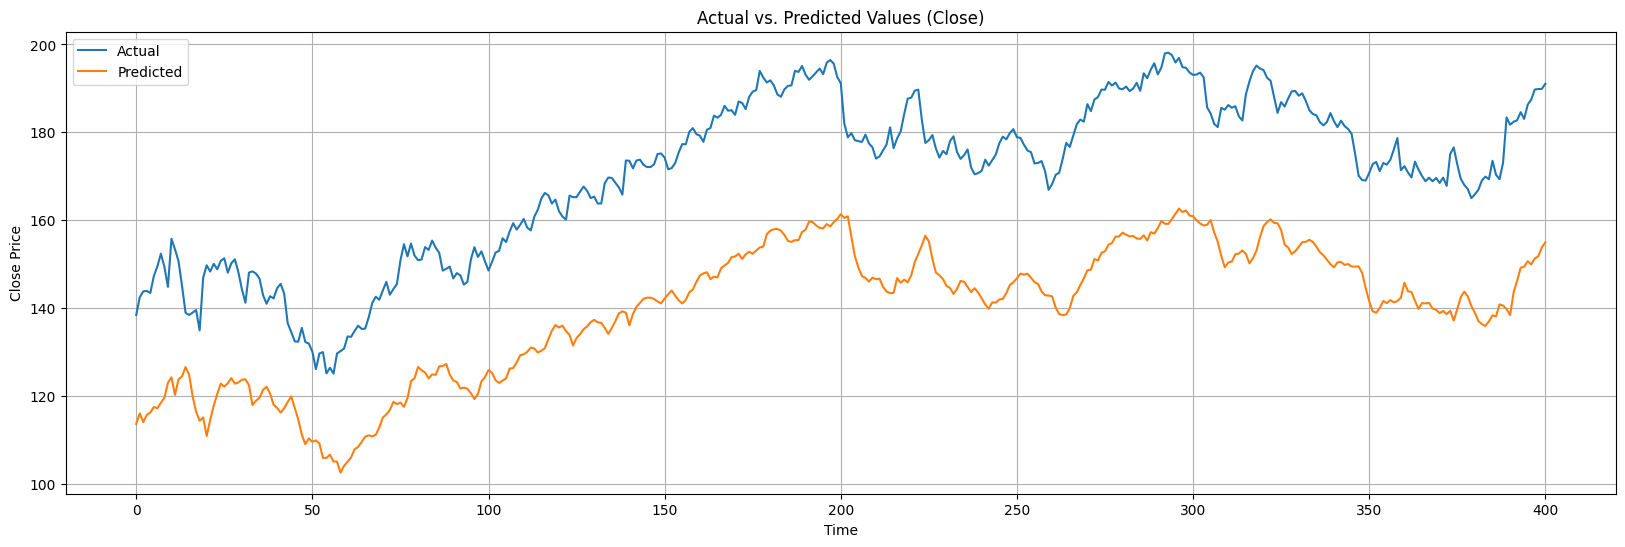

In [140]:
target_variable = 'Close'
train_data, test_data = train_test_data(target_variable)
mlp(target_variable, train_data, test_data)

###Predicting Returns

Epoch 1/50


<ipython-input-126-6d0afc0da764>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target[f'lag_{i}'] = df_target[target_variable].shift(i)


40/40 [==============================] - 1s 7ms/step - loss: 2.5377 - mae: 0.9185 - val_loss: 9.5834 - val_mae: 2.3824
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 2.3426 - mae: 0.9026 - val_loss: 9.5588 - val_mae: 2.3785
Epoch 3/50
40/40 [==============================] - 0s 5ms/step - loss: 2.3851 - mae: 0.9025 - val_loss: 9.5336 - val_mae: 2.3744
Epoch 4/50
40/40 [==============================] - 0s 5ms/step - loss: 2.3855 - mae: 0.8934 - val_loss: 9.5107 - val_mae: 2.3707
Epoch 5/50
40/40 [==============================] - 0s 4ms/step - loss: 2.4284 - mae: 0.9033 - val_loss: 9.4918 - val_mae: 2.3678
Epoch 6/50
40/40 [==============================] - 0s 4ms/step - loss: 2.4717 - mae: 0.9050 - val_loss: 9.4702 - val_mae: 2.3644
Epoch 7/50
40/40 [==============================] - 0s 4ms/step - loss: 2.3463 - mae: 0.8957 - val_loss: 9.4481 - val_mae: 2.3610
Epoch 8/50
40/40 [==============================] - 0s 4ms/step - loss: 2.3500 - mae: 0.8893 - val_lo

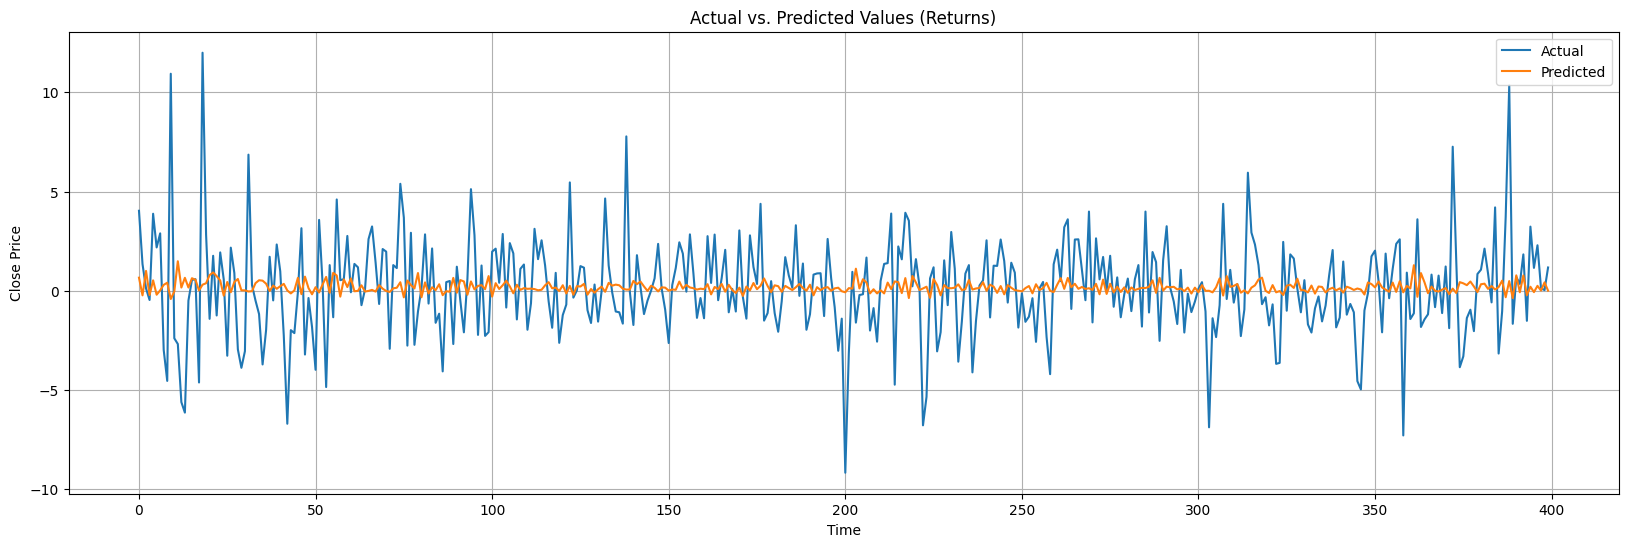

In [141]:
target_variable = 'Returns'
train_data, test_data = train_test_data(target_variable)
mlp(target_variable, train_data, test_data)

###Predicting Fractional differences

<ipython-input-126-6d0afc0da764>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target[f'lag_{i}'] = df_target[target_variable].shift(i)


Epoch 1/50
40/40 [==============================] - 1s 7ms/step - loss: 3.4287 - mae: 1.2396 - val_loss: 12.7430 - val_mae: 2.9103
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 3.3384 - mae: 1.2110 - val_loss: 12.5775 - val_mae: 2.8887
Epoch 3/50
40/40 [==============================] - 0s 4ms/step - loss: 3.3346 - mae: 1.2255 - val_loss: 12.4200 - val_mae: 2.8677
Epoch 4/50
40/40 [==============================] - 0s 4ms/step - loss: 3.3398 - mae: 1.2095 - val_loss: 12.2744 - val_mae: 2.8487
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 3.1823 - mae: 1.1788 - val_loss: 12.1343 - val_mae: 2.8303
Epoch 6/50
40/40 [==============================] - 0s 4ms/step - loss: 3.2170 - mae: 1.1765 - val_loss: 12.0021 - val_mae: 2.8125
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 3.2016 - mae: 1.1692 - val_loss: 11.8764 - val_mae: 2.7952
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 3.1593 - ma

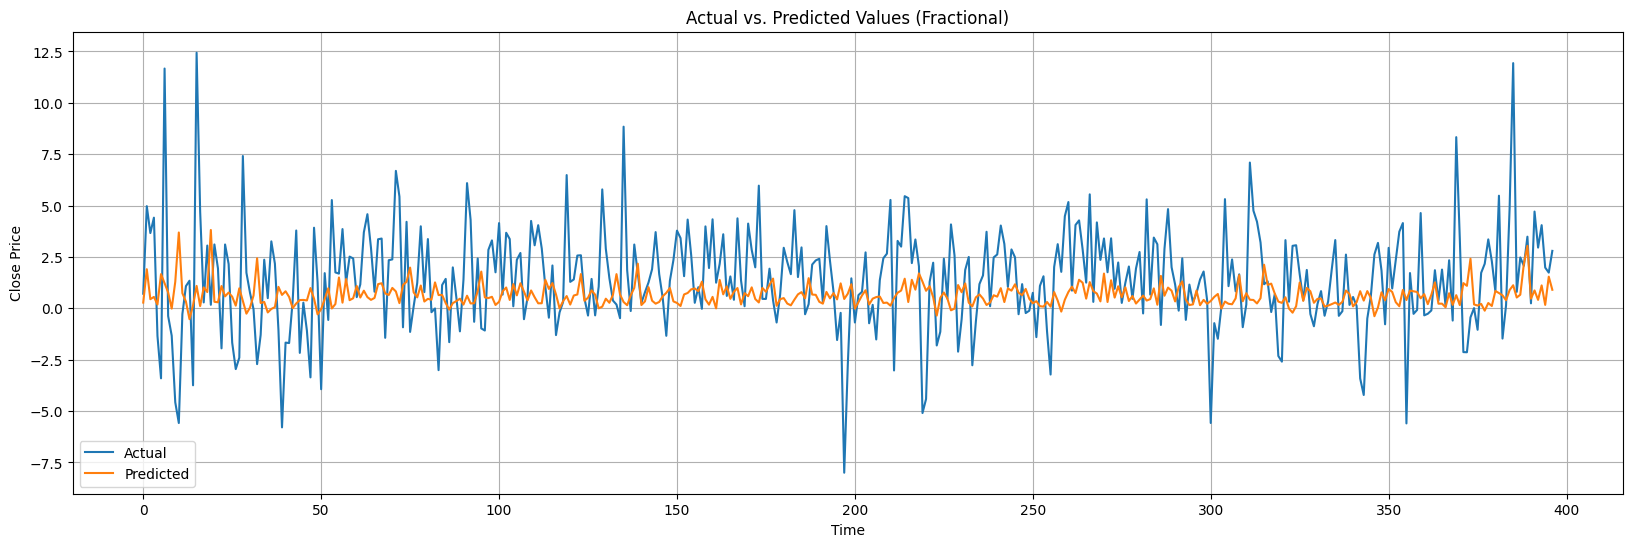

In [135]:
target_variable = 'Fractional'
train_data, test_data = train_test_data(target_variable)
mlp(target_variable, train_data, test_data)

##Convolutional Neural Network (CNN)

In [188]:
def train_test_data_cnn(target_variable):
  Xdf = df.iloc[:,df.columns.get_loc(target_variable)]
  Xdf.dropna(inplace=True)
  X_train = []
  window_size = 30
  for i in range(window_size, Xdf.shape[0]):
    X_train.append(Xdf[i - window_size : i])
  X_train = np.array(X_train)
  #print(X_train.shape)
  # Define a "window_size"-days interval
  days = np.linspace(1, X_train.shape[0], num=X_train.shape[0])
  # Plot the overlapping time series
  #plt.figure(figsize=(6, 6))
  #for i in range(241):
  #  plt.plot(days[i : window_size + i], X_train[i, :])

  transformer = GramianAngularField()
  X_train_new = transformer.transform(X_train)
  #print(X_train_new.shape)

  # Show the results for the first time series
  #fig, ax = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={"width_ratios": [1, 1]})
  #ax[0].plot(X_train[0, :])
  #ax[1].imshow(X_train_new[0], cmap="rainbow")
  #print(X_train_new[0].shape)

  y_data = []
  for i in range(window_size, Xdf.shape[0] - window_size):
    y_data.append(Xdf[i])
  y_data = np.array(y_data)
  #y_data.shape

  X_data = X_train_new[:-window_size]
  for i in range(X_data.shape[0]):
    X_data[i] = (X_data[i] - np.min(X_data[i])) / (
        np.max(X_data[i]) - np.min(X_data[i])
    )
  # We could simply write X_data = (X_data + 1)/2
  X_data = X_data * 255

  # display several time series and the corresponding images
  #fig, ax = plt.subplots(2, 5, figsize=(20, 4))
  #for i in range(0, 125, 25):
  #  ax[0, int(i / 25)].plot(X_train[i])
  #for i in range(0, 125, 25):
  #  ax[1, int(i / 25)].imshow(X_data[i], "gray")

  # Split into train and test
  train_split = 0.8
  y_data_train = y_data[: int(train_split * y_data.shape[0])]
  y_data_test = y_data[int(train_split * y_data.shape[0]) :]
  X_data_train = X_data[: int(train_split * y_data.shape[0])]
  X_data_test = X_data[int(train_split * y_data.shape[0]) :]

  return X_data_train, X_data_test, y_data_train, y_data_test

In [185]:
def cnn(target_variable, X_data_train, X_data_test, y_data_train, y_data_test):
  model = tf.keras.Sequential()
  # Input layer
  model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))
  model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
  model.add(tf.keras.layers.MaxPooling2D(2))
  model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
  model.add(tf.keras.layers.MaxPooling2D(2))
  model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
  model.add(tf.keras.layers.MaxPooling2D(2))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1024, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.5, seed=1234))
  model.add(tf.keras.layers.Dense(1))
  model.summary()

  hp_lr = 1e-5  # Learning rate
  adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
  model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])

  model.fit(
    x=X_data_train,
    y=y_data_train,
    epochs=50,
    validation_data=(X_data_test, y_data_test),
    verbose=1
  )
  loss, mae = model.evaluate(X_data_test, y_data_test)
  print("Test Loss:", loss)
  print("Test MAE:", mae)

  predictions = model.predict(X_data_test)

  plt.figure(figsize=(20, 6))
  plt.plot(y_data_test, label='Actual')
  plt.plot(predictions, label='Predicted')
  plt.title(f'Actual vs. Predicted Values ({target_variable})')
  plt.xlabel('Time')
  plt.ylabel('Close Price')
  plt.legend()
  plt.grid(True)
  plt.show()

###Predicting Price Levels

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 6, 6, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 2, 2, 64)        

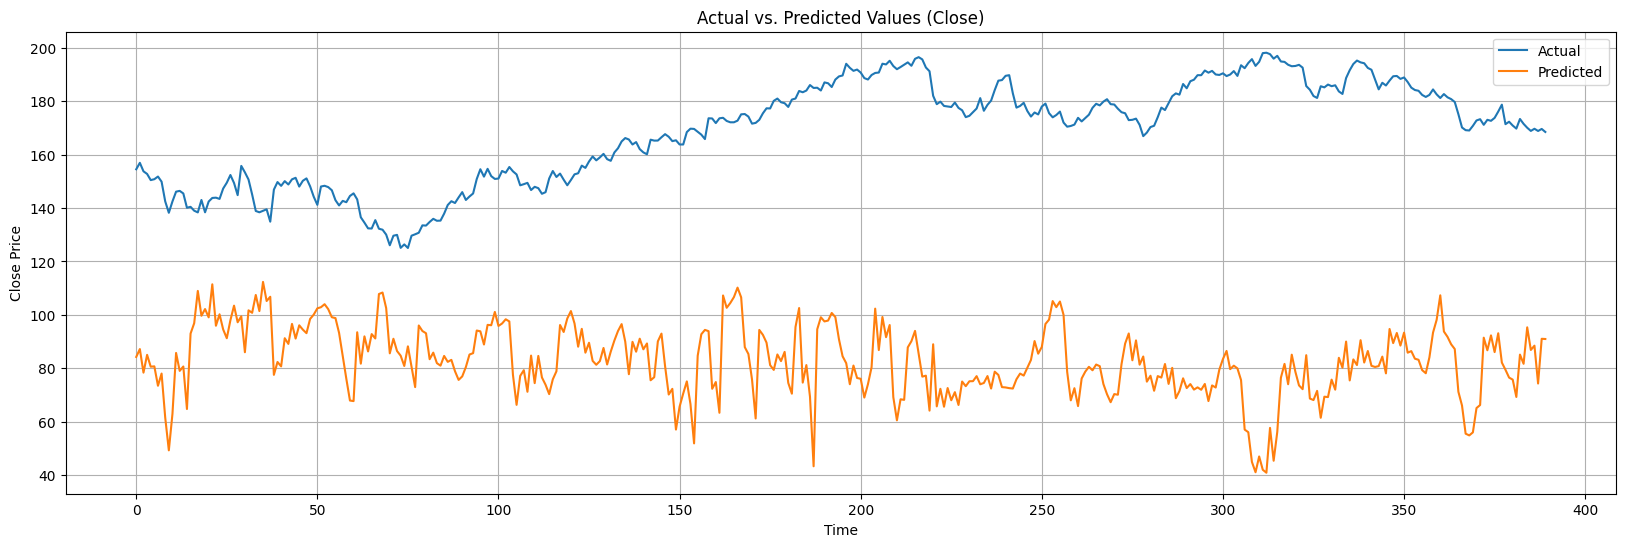

In [189]:
target_variable = 'Close'
X_data_train, X_data_test, y_data_train, y_data_test = train_test_data_cnn(target_variable)
cnn(target_variable, X_data_train, X_data_test, y_data_train, y_data_test)

###Predicting Returns

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 6, 6, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 2, 2, 64)        

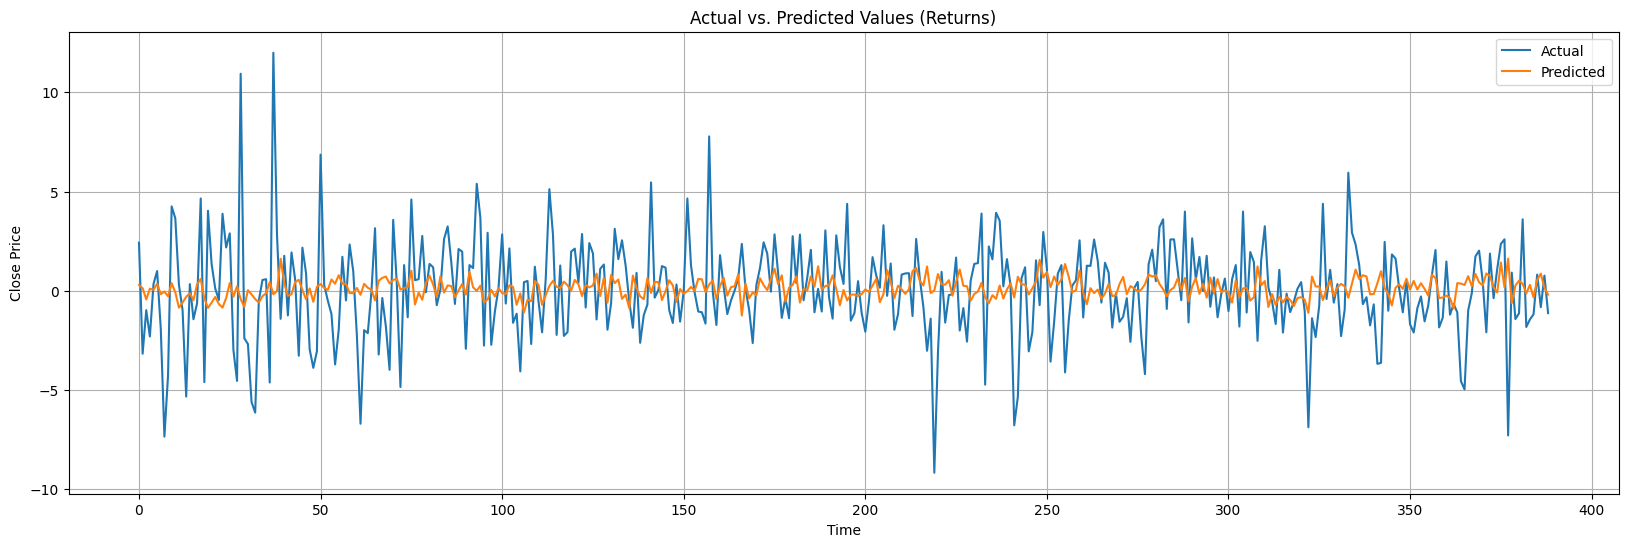

In [190]:
target_variable = 'Returns'
X_data_train, X_data_test, y_data_train, y_data_test = train_test_data_cnn(target_variable)
cnn(target_variable, X_data_train, X_data_test, y_data_train, y_data_test)

###Predicting Fractional differences

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 6, 6, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 2, 2, 64)        

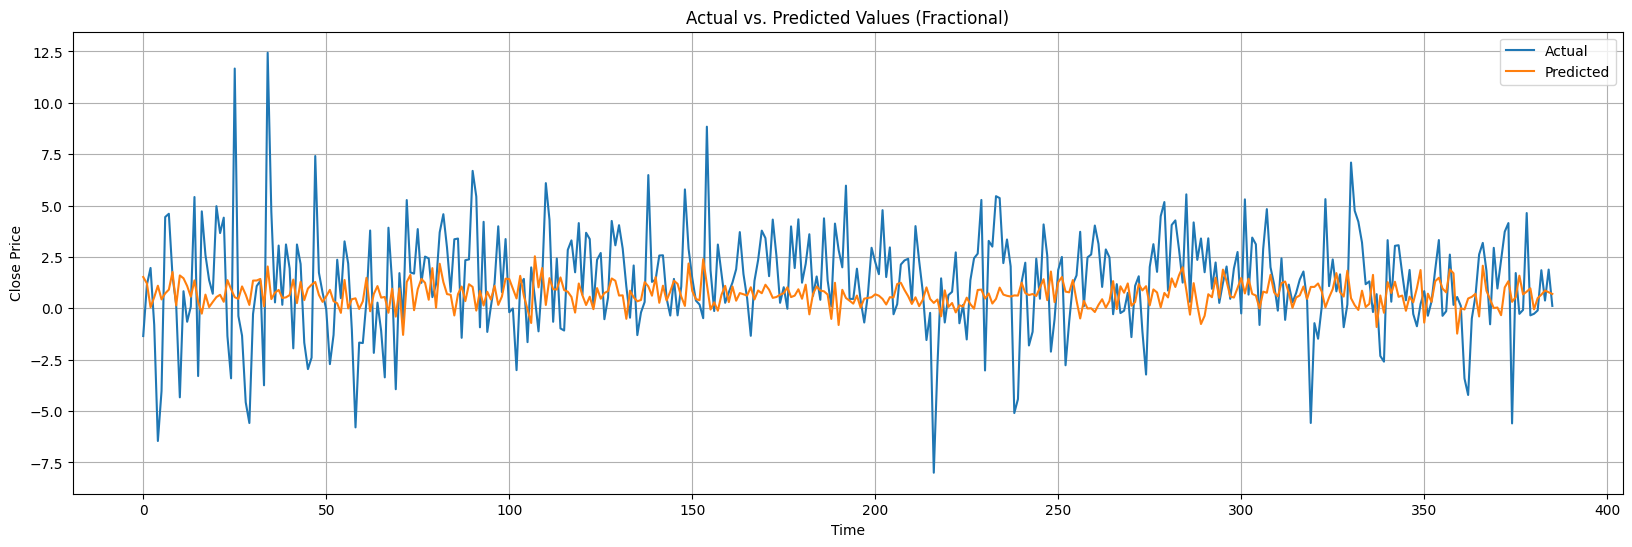

In [191]:
target_variable = 'Fractional'
X_data_train, X_data_test, y_data_train, y_data_test = train_test_data_cnn(target_variable)
cnn(target_variable, X_data_train, X_data_test, y_data_train, y_data_test)